ASL, 29.04.22

# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data, tailored for a given task. 

<img src="https://upload.wikimedia.org/wikipedia/en/8/83/VGG_neural_network.png">

At the end of a high-performance deep neural network, i.e. in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN, and use them to for training other ML models.

We'll do that by using so-called PyTorch **hooks**.

## Hooks in PyTorch

Remember that neural networks are **computational graphs**

![](https://docs.chainer.org/en/latest/_images/googlenet.png)<br>
<center><small>Illustration from <a href="https://docs.chainer.org/en/stable/">https://docs.chainer.org/en/stable/</a> </small></center>

- Hooks are functions injected into these computational graphs by attaching them to tensors or to modules (network layers)
- This allows us to access, and potentially modify, gradients associated with tensors, and the inputs and outputs of layers (modules) as they flow through the computational graphs
- We can attach backward and forward hooks to modules: triggered during backward and forward calculations, respectively.

> In this notebook, we'll attach a hook to the final linear layer of the model to grab the activations before they are passed to the final classification layers. These activations will be a task-specific representation of the data. 

The PyTorch docs has a description of hooks here: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks. See also the Paperspace blog post: https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/. Here's a video tutorial that explains hooks in quite some detail: https://www.youtube.com/watch?v=syLFCVYua6Q. 

# Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd

In [2]:
# If Jedi's not working
%config Completer.use_jedi = False

In [3]:
NB_DIR = Path.cwd()

# Point this to where you stored the MOESM data:
DATA = NB_DIR/'data'/'drug'
RAW_DATA = DATA/'raw'
# Path to image data as defined earlier
IMGDATA = Path('/raid/alex/drugdiscovery/molimages/')

In [4]:
NB_DIR = Path.cwd()
LOCALDATA = NB_DIR/'data'/'drug'/'interim'

In [5]:
from fastai.vision.all import *

# Load data

In [6]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

We remember that we had 7 activity datasets:

In [7]:
# Datasets available:
data = sorted(list(RAW_DATA.glob('CHEM*cl.csv')))
data

[Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL1978_cl.csv'),
 Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL205_cl.csv'),
 Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL218_cl.csv'),
 Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL219_cl.csv'),
 Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL240_cl.csv'),
 Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL244_cl.csv'),
 Path('/home/alex/Dropbox/J

...and that we've generated images of the molecules:

In [8]:
IMGDATA.ls()

(#1) [Path('/raid/alex/drugdiscovery/molimages/CHEMBL1978_cl')]

We'll use the **CHEMBL1978** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [9]:
ds = data[0]
ds

Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL1978_cl.csv')

In [10]:
df, name = get_df(ds)

In [11]:
df.head()

,CID,SMILES,Image,Activity
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       6831 non-null   object
 1   SMILES    6831 non-null   object
 2   Image     6831 non-null   object
 3   Activity  6831 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 213.6+ KB


In [13]:
df['Activity'].value_counts()

0    6210
1     621
Name: Activity, dtype: int64

## Create train-val-split and oversample train

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [16]:
df = val_cols_and_oversample(df)

In [17]:
df.head()

,CID,SMILES,Image,Activity,is_valid
0,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False
1,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False
2,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False
3,CHEMBL1957218,s1cc(nc1-c1ccncc1C)-c1cccnc1,CHEMBL1957218.png,1,False
4,CHEMBL1957223,s1cc(nc1-c1cccnc1)-c1ccc(OC)nc1,CHEMBL1957223.png,1,False


In [18]:
df['Activity'].value_counts()

0    6210
1    4815
Name: Activity, dtype: int64

# Create a dataloader

In [19]:
bs=64

In [20]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [21]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [22]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

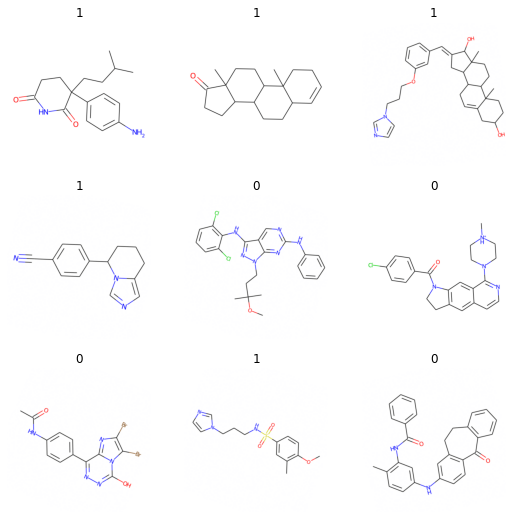

In [23]:
dls.show_batch()

# Train a CNN

In [24]:
from utils import plot_metrics

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [25]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [27]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=2, bias=False)
)

In [28]:
learn = vision_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

In [29]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The below training takes a while. We can rather load the results of a previous run:

In [ ]:
learn = learn.load('chembl1978-model-test-hooks')

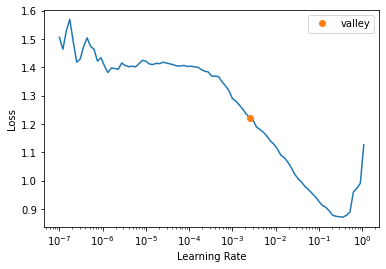

In [30]:
lr = learn.lr_find()

In [31]:
lr.valley

0.002511886414140463

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.595412,0.386222,0.829040,0.484099,0.333333,0.883871,0.927304,0.475389,00:44
1,0.346069,0.266166,0.893443,0.616034,0.457680,0.941935,0.962466,0.612160,00:43
2,0.240827,0.217454,0.915691,0.661972,0.520295,0.909677,0.968332,0.649385,00:43
3,0.195398,0.168734,0.943794,0.734807,0.642512,0.858065,0.968947,0.713318,00:43
4,0.150659,0.123840,0.960187,0.806818,0.720812,0.916129,0.976520,0.791992,00:43
5,0.128720,0.142449,0.953162,0.777778,0.682927,0.903226,0.975639,0.761352,00:43
6,0.126057,0.109264,0.964286,0.821114,0.752688,0.903226,0.979233,0.805570,00:43
7,0.118370,0.120417,0.963700,0.820809,0.743455,0.916129,0.978502,0.806265,00:43
8,0.095689,0.101334,0.968384,0.842105,0.770053,0.929032,0.981480,0.829195,00:43
9,0.091053,0.099678,0.969555,0.846154,0.781421,0.922581,0.982290,0.832911,00:43


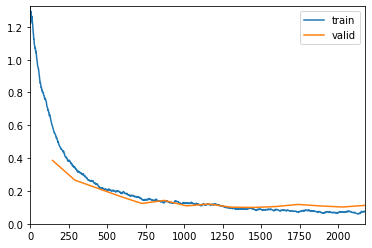

In [32]:
learn.fit_one_cycle(15, slice(lr.valley))

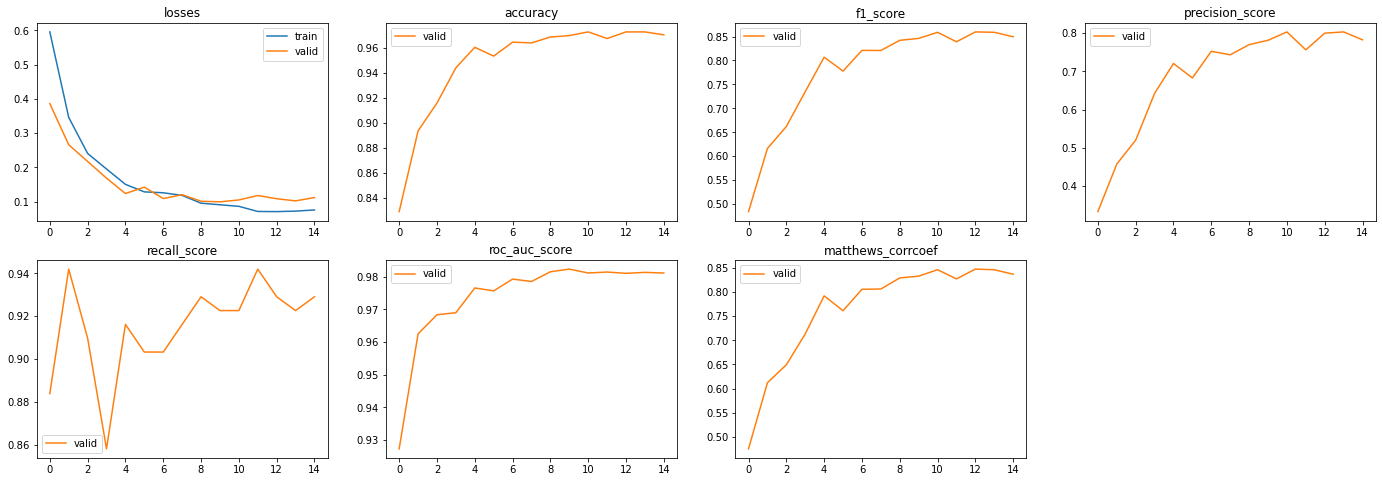

In [33]:
learn.recorder.plot_metrics()

In [34]:
#learn.save('chembl1978-model-test-hooks')

Path('models/chembl1978-model-test-hooks.pth')

### Evaluate

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

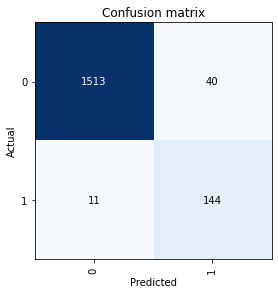

In [36]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a **forward hook** at the layer we want to save activations from:

In [37]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [38]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [39]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [40]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

No data augmentation:

In [41]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [42]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [43]:
test_df = test_dls.items.reset_index()

In [44]:
test_df.head()

,index,CID,SMILES,Image,Activity,is_valid
0,3754,CHEMBL1099326,O(CCCC(=O)[O-])c1cccc(CCCCCCOc2cc(cc(c2)-c2ccncc2)-c2ccncc2)c1CCC(=O)[O-],CHEMBL1099326.png,0,False
1,5869,CHEMBL72290,Clc1cc2-n3c(nnc3CC)C(=Nc2cc1)N(CC)CC,CHEMBL72290.png,0,True
2,5368,CHEMBL1669571,Clc1cnc(N2CC[NH+](CC2)Cc2cn[nH]c2)cc1C(=O)Nc1cc-2c(CCc3c-2n(nc3C(=O)N)-c2ccc(F)cc2)cc1,CHEMBL1669571.png,0,False
3,4131,CHEMBL162000,O(C)c1ccc(cc1)C(=O)Nc1ncnc(c1)-c1ccccc1,CHEMBL162000.png,0,True
4,979,CHEMBL289867,s1c2C3C([NH2+]Cc2cc1CCCC)CCc1cc(O)c(O)cc13,CHEMBL289867.png,0,False


Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [45]:
test_dls.dataset[0]

(PILImage mode=RGB size=500x500, TensorCategory(0))

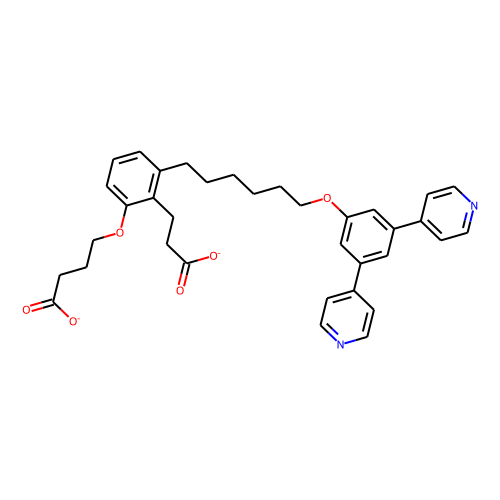

In [46]:
test_dls.dataset[0][0]

In [47]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [48]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [49]:
df_acts = pd.read_csv('data/chembl1978_cnn_activations.csv')

In [50]:
%%time
%%capture
df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

CPU times: user 56min 26s, sys: 3min 1s, total: 59min 28s
Wall time: 2min 58s


Now we've stored activations for each image:

In [51]:
df_nodupl.head()

,CID,SMILES,Image,Activity,is_valid,activations
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1,True,"[-4.53223, 1.2242482, 1.9664226, -8.38185, -4.273423, 1.6188779, 3.7000856, 1.9149464, -0.5070727, -1.7810575, -1.0826144, 3.7163599, -3.6440969, -2.821131, -1.6827817, 1.4073136, 10.514254, 2.9001305, 9.069101, 0.62642336, 1.4808394, -0.43103516, 0.51418424, 5.476626, 5.684493, 1.4106046, -4.502261, -0.041307926, -4.277829, 7.254024, -2.5529473, -4.70026, -3.9301422, 3.6659029, 2.6201236, 4.127348, 0.6816625, -8.893678, -5.2777257, 14.204137, 11.411678, 6.9298425, 5.9012594, 7.9898434, -5.566207, 5.7564917, -0.21323794, -8.678903, 1.5133169, 2.8930807, 3.1604161, -2.8626711, -0.5543872, 1..."
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False,"[-1.8085067, -4.563689, 5.8950977, -10.517269, -1.1766489, -2.424201, 1.5980039, 1.5070074, -0.47416982, 1.2013993, 1.4520941, 2.881032, -0.7297743, 1.7631106, -3.9904108, -0.7238305, 13.878513, 1.5754188, 10.091096, -0.14215557, -0.5309795, -0.09478608, -0.29546154, 5.6839347, 5.9349084, -1.4218488, -3.0453534, -3.5025253, -1.8201551, 7.0253, 2.1401703, -7.2793655, -1.3667877, 2.7091825, 0.65315354, 6.714842, 1.1927533, -5.495879, -4.1608295, 13.203564, 11.545866, 6.9664016, 5.035795, 5.318619, -6.6456337, -0.137097, -1.8969784, -2.4927802, 4.462484, -1.902673, 6.086036, 0.34105992, -1.03..."
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1,True,"[-8.560979, 0.8466887, 0.04911995, -1.3273535, -7.7300177, 4.565922, -4.1915846, -1.764997, -2.5185494, -2.457241, -10.590738, -2.644333, -1.7243022, 1.6650659, 1.6540964, -7.8155947, 6.8335743, 1.4190893, 7.996589, -1.0538796, -4.3098564, -11.66593, -0.06596339, 1.997009, 2.3858044, 0.99863046, -5.3724327, -0.2871377, -5.553808, 5.2316265, 1.0553379, 2.0277297, 0.7701553, -7.7753677, 3.348153, 2.719956, 0.94390154, -8.071663, -2.2701035, 4.3410068, 3.6034, 0.043355584, -0.18587643, 7.4026394, -7.6462984, 3.3223839, -0.1927008, -0.844993, 3.898232, 5.4499264, 6.1207914, -0.5805237, -5.3426..."
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False,"[-5.60823, -2.2384725, -7.5115576, -10.029954, -2.4023404, 0.27814567, -3.1740134, -3.020409, -2.2920034, -0.7895498, -4.192891, -0.6451576, 0.66397333, 11.179311, 0.54573524, -0.5670787, 9.897324, 4.229731, 8.87864, 0.5055133, -4.521607, -6.607569, 4.98999, 4.6932096, 3.4797068, 0.9627744, -3.2298226, -2.092463, -6.479858, -2.9965525, 12.497225, 4.777813, -2.0509143, -3.8167362, -1.8357153, 8.385421, -0.22200036, -2.094059, -6.2205443, 7.7447834, 6.577692, 7.643581, 8.925291, 5.0250587, -13.838637, 3.6536374, 0.96409047, -3.661319, 7.368491, 5.257421, 7.520189, 8.033947, -1.2555246, -0.80..."
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False,"[-8.388573, -0.21037412, -9.306, -9.646712, -0.5238982, 1.3715866, -2.346459, -0.06696236, -0.6317121, 0.88646007, -3.4741669, -2.2147894, -2.4929113, 10.022305, -0.29252034, -1.857451, 11.069161, 4.3911877, 11.498993, 1.0456141, -2.0607042, -4.582257, 2.8146815, 7.6149855, 5.019865, 1.7000593, -2.2824886, -0.91600585, -8.482963, -1.1804818, 8.996607, 4.9881926, -3.9486828, -4.4946012, -1.2531947, 9.618689, 2.6391692, 0.09990281, -1.6731544, 8.284986, 7.0007343, 7.290529, 8.571828, 7.06732, -14.190914, 0.7056502, 1.7662197, -7.4479322, 5.726438, 6.7614393, 7.577806, 6.3227415, 0.18382734, ..."


We split the activations to have one column for each, as they will be treated as separate features later:

In [52]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [53]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [54]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1,True,-4.532230,1.224248,1.966423,-8.381850,-4.273423,...,1.763183,4.787558,-0.030395,0.706915,4.570997,-4.053734,1.609689,-9.081184,-3.181017,-0.203582
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False,-1.808507,-4.563689,5.895098,-10.517269,-1.176649,...,1.855113,5.819135,1.286643,0.472754,5.768912,-6.418476,0.230072,-10.999625,-1.719881,0.570552
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1,True,-8.560979,0.846689,0.049120,-1.327353,-7.730018,...,-3.007366,3.108833,-8.790288,1.812331,6.819275,-4.330555,-0.905350,-2.298186,-4.472672,2.156450
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False,-5.608230,-2.238472,-7.511558,-10.029954,-2.402340,...,-2.008709,2.589823,-5.040246,-3.112130,7.388686,1.422117,-1.783719,-1.335929,-2.932731,-7.631751
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False,-8.388573,-0.210374,-9.306000,-9.646712,-0.523898,...,-0.859448,4.472140,-4.902832,-2.552387,9.227387,2.896422,-1.879456,-0.274850,0.562973,-7.948639


In [55]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: float32(128), int64(1), object(4)
memory usage: 3.6+ MB


In [56]:
df_acts.to_csv('data/chembl1978_with_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `1.0-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [57]:
#df_ecfp = pd.read_csv(LOCALDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [58]:
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 53.5+ MB


In [60]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: float32(128), int64(1), object(4)
memory usage: 3.6+ MB


In [61]:
df = df_ecfp.merge(df_acts, on='CID')

In [62]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,1.763183,4.787558,-0.030395,0.706915,4.570997,-4.053734,1.609689,-9.081184,-3.181017,-0.203582
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,1.855113,5.819135,1.286643,0.472754,5.768912,-6.418476,0.230072,-10.999625,-1.719881,0.570552
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-3.007366,3.108833,-8.790288,1.812331,6.819275,-4.330555,-0.905350,-2.298186,-4.472672,2.156450
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-2.008709,2.589823,-5.040246,-3.112130,7.388686,1.422117,-1.783719,-1.335929,-2.932731,-7.631751
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-0.859448,4.472140,-4.902832,-2.552387,9.227387,2.896422,-1.879456,-0.274850,0.562973,-7.948639


In [63]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [64]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,1.763183,4.787558,-0.030395,0.706915,4.570997,-4.053734,1.609689,-9.081184,-3.181017,-0.203582
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,1.855113,5.819135,1.286643,0.472754,5.768912,-6.418476,0.230072,-10.999625,-1.719881,0.570552
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-3.007366,3.108833,-8.790288,1.812331,6.819275,-4.330555,-0.905350,-2.298186,-4.472672,2.156450
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-2.008709,2.589823,-5.040246,-3.112130,7.388686,1.422117,-1.783719,-1.335929,-2.932731,-7.631751
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-0.859448,4.472140,-4.902832,-2.552387,9.227387,2.896422,-1.879456,-0.274850,0.562973,-7.948639


In [65]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [66]:
LOCALDATA

Path('/home/alex/Dropbox/Jobb/projects/ML/medGPU1-alex/HVL-MMIV-DLN-AI-2022/1-deep_learning/Part-2-practical_deep_learning/nbs/data/drug/interim')

In [67]:
df.to_csv(LOCALDATA/'chembl1978-data-with-ecfp-activations.csv', index=None)

# Train machine learning models on extracted features

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [68]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [69]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [70]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [71]:
X_train.head()

,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,ECFP4_9,ECFP4_10,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
1,0,0,0,0,0,0,0,0,0,0,...,1.855113,5.819135,1.286643,0.472754,5.768912,-6.418476,0.230072,-10.999625,-1.719881,0.570552
3,0,0,0,0,0,0,0,0,0,0,...,-2.008709,2.589823,-5.040246,-3.112130,7.388686,1.422117,-1.783719,-1.335929,-2.932731,-7.631751
4,0,0,0,0,0,0,0,0,0,0,...,-0.859448,4.472140,-4.902832,-2.552387,9.227387,2.896422,-1.879456,-0.274850,0.562973,-7.948639
5,0,0,0,0,0,0,0,0,0,0,...,-0.170992,9.263041,-2.363202,1.314156,9.264038,-2.372291,1.036324,-9.633930,-1.235161,1.429714
8,0,0,0,0,0,0,0,0,0,0,...,-2.640293,5.206597,0.416759,0.509764,6.881524,-5.670618,-7.971480,-7.454432,-4.715279,-0.797282


In [72]:
y_train.head()

1    1
3    1
4    1
5    1
8    1
Name: Activity, dtype: int64

### Logistic Regression and Random forest

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [74]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score)

In [75]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f"AUC: {auc.round(5)}, Acc: {acc2.round(5)}, MCC: {mcc.round(5)}")
    print(f"Recall: {Recall.round(5)}, Precision: {Precision.round(5)}, F1_score: {F1_score.round(5)}")

    return auc,acc2,mcc,Recall,Precision,F1_score, lr

In [76]:
def train_rf(X_train, X_test, y_train, y_test, n_estimators=100, 
             criterion='gini', max_features='log2', features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Following the settings in the paper, `RF_tune.py`
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=2, 
                                    max_features=max_features, max_leaf_nodes=None, 
                                    bootstrap=False,oob_score=False, n_jobs=-1, 
                                    random_state=100)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f"AUC: {auc.round(5)}, Acc: {acc2.round(5)}, MCC: {mcc.round(5)}")
    print(f"Recall: {Recall.round(5)}, Precision: {Precision.round(5)}, F1_score: {F1_score.round(5)}")

    return auc,acc2,mcc,Recall,Precision,F1_score, rf

**Logistic regression:**

In [77]:
_ = train_lr(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.98444, Acc: 0.97541, MCC: 0.85188
Recall: 0.87097, Precision: 0.85987, F1_score: 0.86538


In [78]:
_ = train_lr(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.97439, Acc: 0.96019, MCC: 0.75333
Recall: 0.75484, Precision: 0.79592, F1_score: 0.77483


In [79]:
_ = train_lr(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.98382, Acc: 0.97424, MCC: 0.84577
Recall: 0.87097, Precision: 0.84906, F1_score: 0.85987


**Random forest:**

In [80]:
_ = train_rf(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.99229, Acc: 0.97951, MCC: 0.87051
Recall: 0.81935, Precision: 0.94776, F1_score: 0.87889


In [81]:
_ = train_rf(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.9732, Acc: 0.97131, MCC: 0.81809
Recall: 0.78065, Precision: 0.88971, F1_score: 0.83162


In [82]:
_ = train_rf(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.97675, Acc: 0.97248, MCC: 0.82503
Recall: 0.78065, Precision: 0.90299, F1_score: 0.83737
